In [6]:
import pandas as pd
import re
from textblob import TextBlob
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import bigrams
import matplotlib.pyplot as plt
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
from wordcloud import WordCloud
import requests
from urllib.parse import urlparse
import string
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/u1418526/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/u1418526/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/u1418526/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('twcs.csv',parse_dates=['created_at'])
df.head

/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_14455/436385448.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('twcs.csv',parse_dates=['created_at'])


<bound method NDFrame.head of          tweet_id   author_id  inbound                created_at  \
0               1  sprintcare    False 2017-10-31 22:10:47+00:00   
1               2      115712     True 2017-10-31 22:11:45+00:00   
2               3      115712     True 2017-10-31 22:08:27+00:00   
3               4  sprintcare    False 2017-10-31 21:54:49+00:00   
4               5      115712     True 2017-10-31 21:49:35+00:00   
...           ...         ...      ...                       ...   
2811769   2987947  sprintcare    False 2017-11-22 08:43:51+00:00   
2811770   2987948      823869     True 2017-11-22 08:35:16+00:00   
2811771   2812240      121673     True 2017-11-23 04:13:07+00:00   
2811772   2987949      AldiUK    False 2017-11-22 08:31:24+00:00   
2811773   2987950      823870     True 2017-11-21 22:01:04+00:00   

                                                      text response_tweet_id  \
0        @115712 I understand. I would like to assist y...               

In [4]:
# Convert the 'created_at' column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

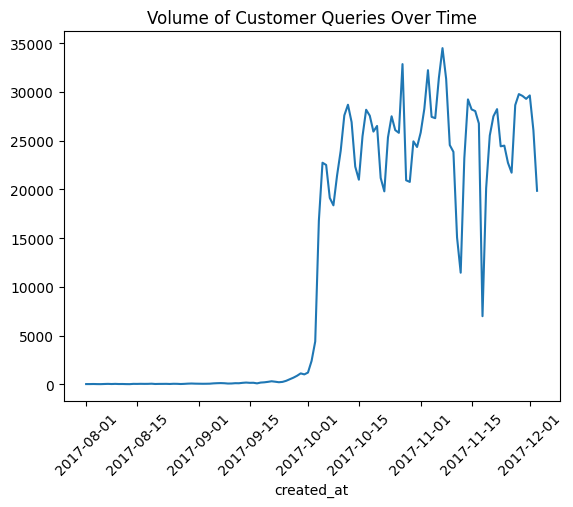

In [5]:
# --- VOLUME AND TRENDS ---
# Track the volume of customer queries over time
volume_over_time = df[df['inbound'] == True].groupby(df['created_at'].dt.date).size()
filtered_df = df[(df['created_at'].dt.year >= 2017) & (df['created_at'].dt.month >= 8) & (df['inbound'] == True)]

# Group by date and calculate the size
volume_over_time = filtered_df.groupby(filtered_df['created_at'].dt.date).size()

# Plot the data
volume_over_time.plot(title='Volume of Customer Queries Over Time')
plt.xticks(rotation=45) 
plt.show()

In [6]:
# --- EFFECTIVENESS OF SUPPORT ---
merged = df.merge(df, left_on='tweet_id', right_on='in_response_to_tweet_id')
responses = merged[merged['inbound_x'] & ~merged['inbound_y']]
responses['response_time'] = (responses['created_at_y'] - responses['created_at_x']).dt.total_seconds() / 60
print("Average Response Time by Support Account:")
average_response_time = responses.groupby('author_id_y')['response_time'].mean().sort_values()
print(average_response_time)

Average Response Time by Support Account:
author_id_y
VerizonSupport        7.742148
LondonMidland         8.643067
nationalrailenq       9.715906
AlaskaAir            10.566140
TMobileHelp          12.037595
                      ...     
ATVIAssist         2599.956046
airtel_care        3310.178171
askvisa            3397.091655
TfL                3536.593297
SCsupport          4465.224600
Name: response_time, Length: 108, dtype: float64


/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_96127/1286442864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responses['response_time'] = (responses['created_at_y'] - responses['created_at_x']).dt.total_seconds() / 60


/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_96127/229376579.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_support_accounts.values, y=top_10_support_accounts.index, palette='viridis')


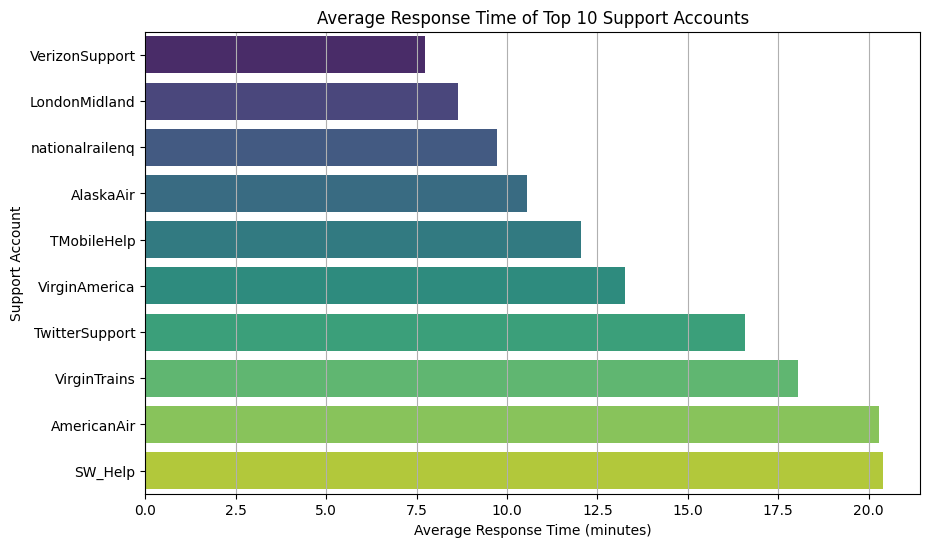

In [7]:
top_10_support_accounts = average_response_time.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_support_accounts.values, y=top_10_support_accounts.index, palette='viridis')
plt.title('Average Response Time of Top 10 Support Accounts')
plt.xlabel('Average Response Time (minutes)')
plt.ylabel('Support Account')
plt.grid(axis='x')
plt.show()

In [31]:
# --- USER ENGAGEMENT PATTERNS ---
user_counts = df[df['inbound'] == True]['author_id'].value_counts()
frequent_users = user_counts[user_counts > user_counts.mean() + 2 * user_counts.std()].index.tolist()

# Extract queries from frequent users
frequent_user_queries = df[df['author_id'].isin(frequent_users)]['text']

# Function to get common themes, excluding stop words
def get_common_themes(texts):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Adding custom words to stop words
    custom_stop_words = ['u']
    stop_words.update(custom_stop_words)

    words = ' '.join(texts).lower().split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]

    # Getting top single words
    top_words = pd.Series(filtered_words).value_counts().head(15)

    # Getting top bigrams
    top_bigrams = pd.Series(list(bigrams(filtered_words))).value_counts().head(15)

    return top_words, top_bigrams

print("\nCommon Themes for Frequent Users:")
top_words, top_bigrams = get_common_themes(frequent_user_queries)
print("Top Words:\n", top_words)
print("\nTop Bigrams:\n", top_bigrams)


Common Themes for Frequent Users:
Top Words:
 get         15175
time         9543
still        9511
service      9339
customer     8527
one          8203
please       8142
day          7790
need         7278
like         6795
would        6178
want         6132
help         6125
know         6121
call         6047
Name: count, dtype: int64

Top Bigrams:
 (customer, service)    2284
(customer, care)        747
(still, waiting)        697
(look, like)            664
(let, know)             648
(iphone, x)             544
(please, help)          537
(would, like)           533
(get, back)             513
(many, time)            490
(make, sure)            488
(every, time)           472
(even, though)          459
(response, day)         449
(kind, response)        449
Name: count, dtype: int64


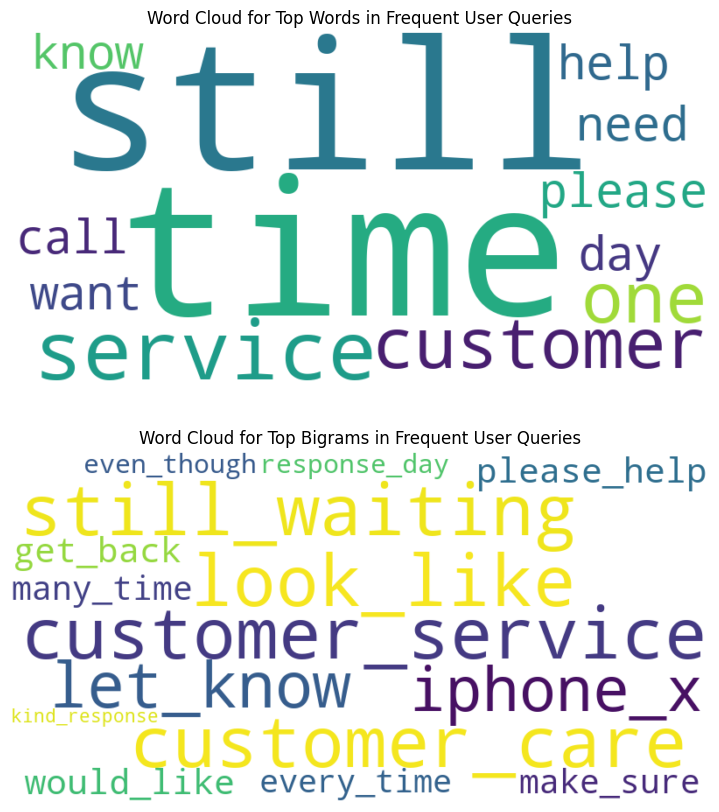

In [32]:
# Word Cloud for Top Words
wordcloud_words = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_words.index))

# Word Cloud for Top Bigrams (replacing spaces with underscores for better visualization)
wordcloud_bigrams = WordCloud(width=800, height=400, background_color='white').generate(" ".join(["_".join(bigram) for bigram in top_bigrams.index])
)

# Display the word clouds using matplotlib
plt.figure(figsize=(15, 10))

# Word Cloud for Top Words
plt.subplot(2, 1, 1)
plt.imshow(wordcloud_words, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Top Words in Frequent User Queries')

# Word Cloud for Top Bigrams
plt.subplot(2, 1, 2)
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Top Bigrams in Frequent User Queries')
plt.show()

In [34]:
# Define less frequent users
less_frequent_users = user_counts[user_counts <= user_counts.mean() + 2 * user_counts.std()].index.tolist()

# Calculate average response time for less frequent users
avg_response_time_less_frequent = responses[responses['author_id_x'].isin(less_frequent_users)].groupby('author_id_x')['response_time'].mean()

# Calculate average response length for less frequent users
avg_response_length_less_frequent = responses[responses['author_id_x'].isin(less_frequent_users)].groupby('author_id_x')['response_length'].mean()

# Explore response times for users with more interactions
merged = df.merge(df, left_on='tweet_id', right_on='in_response_to_tweet_id')
responses = merged[merged['inbound_x'] & ~merged['inbound_y']]
responses['response_time'] = (responses['created_at_y'] - responses['created_at_x']).dt.total_seconds() / 60  # in minutes
avg_response_time_frequent_users = responses[responses['author_id_x'].isin(frequent_users)].groupby('author_id_x')['response_time'].mean()
responses['response_length'] = responses['text_y'].apply(len)
avg_response_length_frequent_users = responses[responses['author_id_x'].isin(frequent_users)].groupby('author_id_x')['response_length'].mean()


avg_time_frequent = avg_response_time_frequent_users.mean()
avg_time_less_frequent = avg_response_time_less_frequent.mean()
avg_length_frequent = avg_response_length_frequent_users.mean()
avg_length_less_frequent = avg_response_length_less_frequent.mean()

print(f"Average Response Time - Frequent Users: {avg_time_frequent} minutes")
print(f"Average Response Time - Less Frequent Users: {avg_time_less_frequent} minutes")
print(f"Average Response Length - Frequent Users: {avg_length_frequent} characters")
print(f"Average Response Length - Less Frequent Users: {avg_length_less_frequent} characters")

/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_21884/690311926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responses['response_time'] = (responses['created_at_y'] - responses['created_at_x']).dt.total_seconds() / 60  # in minutes


Average Response Time - Frequent Users: 155.2545773602108 minutes
Average Response Time - Less Frequent Users: 340.59136694306574 minutes
Average Response Length - Frequent Users: 116.7634359633314 characters
Average Response Length - Less Frequent Users: 120.0282607766991 characters


/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_21884/690311926.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responses['response_length'] = responses['text_y'].apply(len)


Text(0, 0.5, 'Average Response Time (minutes)')

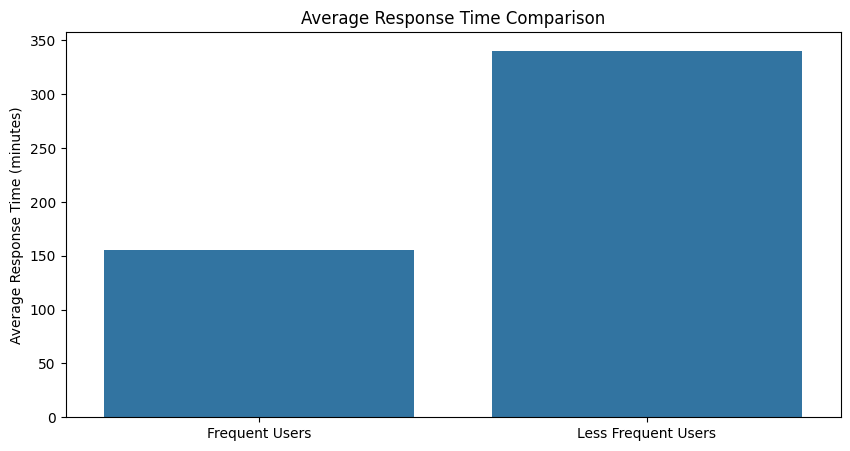

In [35]:
# Bar plot for average response times
plt.figure(figsize=(10, 5))
sns.barplot(x=['Frequent Users', 'Less Frequent Users'], y=[avg_time_frequent, avg_time_less_frequent])
plt.title('Average Response Time Comparison')
plt.ylabel('Average Response Time (minutes)')

Text(0, 0.5, 'Average Response Length (characters)')

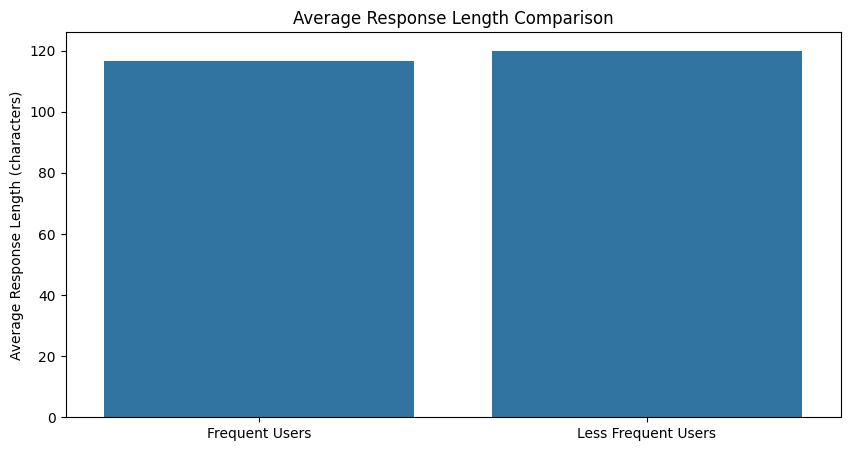

In [48]:
# Bar plot for average response lengths
plt.figure(figsize=(10, 5))
sns.barplot(x=['Frequent Users', 'Less Frequent Users'], y=[avg_length_frequent, avg_length_less_frequent])
plt.title('Average Response Length Comparison')
plt.ylabel('Average Response Length (characters)')

In [49]:
# --- LINK ANALYSIS ---
support_responses = df[df['inbound'] == False]
support_responses['links'] = support_responses['text'].apply(lambda x: re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x))
all_links = [link for sublist in support_responses['links'].tolist() for link in sublist]
link_frequency = pd.Series(all_links).value_counts()
print("\nMost Common Links:")
print(link_frequency.head(10))

/var/folders/hz/47860bw92z797sc4tg_x_8240000gq/T/ipykernel_21884/3874376171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  support_responses['links'] = support_responses['text'].apply(lambda x: re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x))



Most Common Links:
https://t.co/GDrqU22YpT    53988
https://t.co/wKJHDXWGRQ    14317
https://t.co/ldFdZRiNAt    10136
https://t.co/xXaXeeSRt9     7156
https://t.co/SXpdictw1A     5330
https://t.co/JzP7hlA23B     5295
https://t.co/hApLpMlfHN     4923
https://t.co/6iDGBJAc2m     4837
https://t.co/MdMtnTlX6H     4516
https://t.co/LBfZgLCSfr     4261
Name: count, dtype: int64


In [55]:
def resolve_url(url):
    try:
        response = requests.head(url, allow_redirects=True, timeout=5)
        if response.status_code == 200:
            return response.url
        else:
            return url
    except requests.RequestException:
        return url

# Resolve shortened URLs
resolved_urls = [resolve_url(url) for url in all_links[:500]]

# Extract domains from URLs
domains = [urlparse(url).netloc for url in resolved_urls]

# Count frequencies of each domain
domain_frequency = pd.Series(domains).value_counts()
print("\nMost Common Domains:")
print(domain_frequency.head(20))


Most Common Domains:
t.co                      411
t-mo.io                    16
support.apple.com           9
open.spotify.com            6
helpx.adobe.com             6
support.xbox.com            5
getsupport.apple.com        5
help.hulu.com               4
support.activision.com      3
www.southwest.com           3
www.bing.com                3
community.spotify.com       2
blog.playstation.com        2
help.apple.com              1
www.alaskalistens.com       1
help.dropbox.com            1
www.playstation.com         1
www.amazon.in               1
store.playstation.com       1
www.dropbox.com             1
Name: count, dtype: int64


In [71]:
# --- LANGUAGE AND TEXT PATTERNS ---
negative_tweets = df[(df['inbound'] == True) & (df['text'].apply(lambda x: TextBlob(x).sentiment.polarity) < -0.5)]['text']

# Define a set of stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(re.escape(p) for p in string.punctuation)

# Tokenize tweets and filter out stop words, punctuation, and common terms like 'https'
filtered_bigrams = []
for tweet in negative_tweets:
    words = nltk.word_tokenize(tweet)
    words_filtered = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuation and word.lower() != 'https' and word.isalpha()]
    
    # Generate bigrams and filter out any bigram containing stop words or punctuation
    tweet_bigrams = list(bigrams(words_filtered))
    tweet_bigrams_filtered = [bigram for bigram in tweet_bigrams if all(word not in stop_words and word not in punctuation for word in bigram)]
    filtered_bigrams.extend(tweet_bigrams_filtered)

# Count frequencies of each bigram
bigram_frequency = nltk.FreqDist(filtered_bigrams)
top_bigrams = bigram_frequency.most_common(10)

print("Common Phrases or Keywords Expressing Dissatisfaction or Urgency:")
bigram_list=[]
for bigram, frequency in top_bigrams:
    bigram_list.append(bigram)
    print(bigram, frequency)

Common Phrases or Keywords Expressing Dissatisfaction or Urgency:
('customer', 'service') 4200
('worst', 'customer') 1262
('service', 'ever') 724
('worst', 'service') 705
('worst', 'experience') 513
('terrible', 'service') 462
('please', 'fix') 431
('terrible', 'customer') 416
('please', 'help') 413
('every', 'time') 384


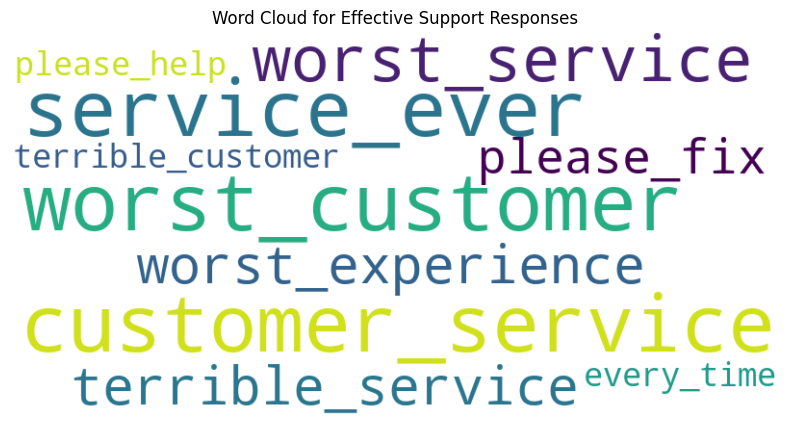

In [72]:
dissatisfaction_bigrams_string = " ".join(["_".join(i) for i in bigram_list])

# Generate the word cloud
wordcloud_dissatisfaction = WordCloud(width=800, height=400, background_color='white').generate(dissatisfaction_bigrams_string)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_dissatisfaction, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Dissatisfaction or Urgency')
plt.show()

In [60]:
effective_responses = merged[(merged['inbound_x'] == False) & (merged['author_id_x'] != merged['author_id_y']) & (merged['text_x'].apply(lambda x: TextBlob(x).sentiment.polarity) > 0.5)]['text_x']

# Define a set of stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(re.escape(p) for p in string.punctuation)

# Tokenize responses and filter out stop words, punctuation, and common terms like 'https'
filtered_bigrams_effective = []
for response in effective_responses:
    words = nltk.word_tokenize(response)
    words_filtered = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuation and word.lower() != 'https' and word.isalpha()]
    
    # Generate bigrams and filter out any bigram containing stop words or punctuation
    response_bigrams = list(bigrams(words_filtered))
    response_bigrams_filtered = [bigram for bigram in response_bigrams if all(word not in stop_words and word not in punctuation for word in bigram)]
    filtered_bigrams_effective.extend(response_bigrams_filtered)

# Count frequencies of each bigram
bigram_frequency_effective = nltk.FreqDist(filtered_bigrams_effective)
top_bigrams_effective = bigram_frequency_effective.most_common(10)

print("Common Phrases in Effective Support Responses:")
bigram_list=[]
for bigram, frequency in top_bigrams_effective:
    bigram_list.append(bigram)
    print(bigram, frequency)

Common Phrases in Effective Support Responses:
('happy', 'help') 4418
('send', 'us') 2310
('us', 'know') 2178
('dm', 'us') 2171
('let', 'us') 2098
('happy', 'look') 2089
('please', 'dm') 1736
('us', 'dm') 1638
('would', 'happy') 1428
('please', 'send') 1382


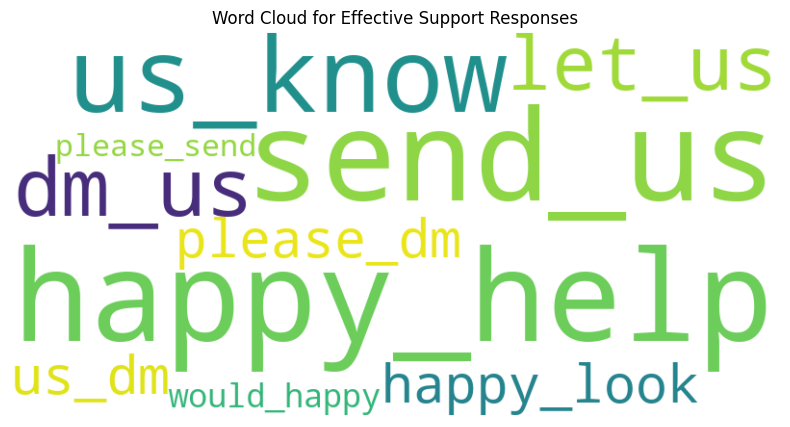

In [70]:
effective_bigrams_string = " ".join(["_".join(i) for i in bigram_list])
# Generate the word cloud
wordcloud_effective = WordCloud(width=800, height=400, background_color='white').generate(effective_bigrams_string)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_effective, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Effective Support Responses')
plt.show()

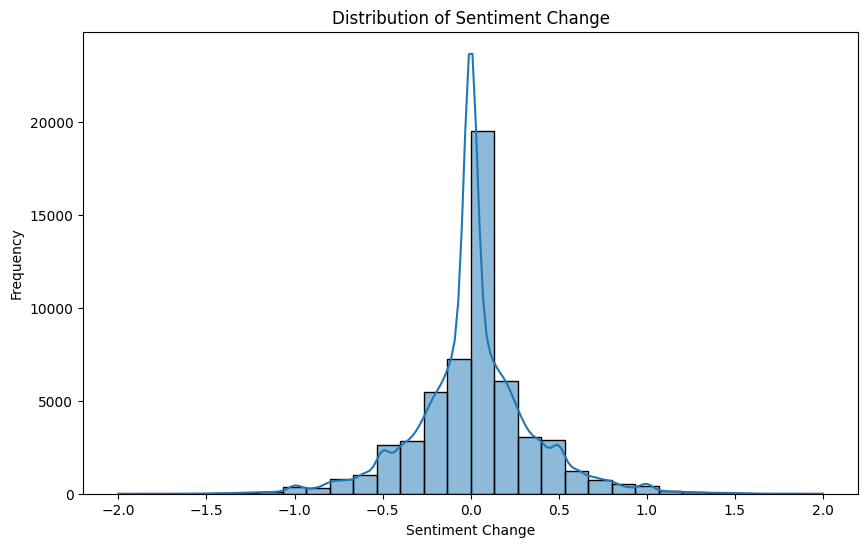

Average Sentiment Change for Follow-Ups: 0.014443029884957697
Median Sentiment Change for Follow-Ups: 0.0


In [74]:
# Function to get sentiment polarity
def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

# Filter out only the inbound tweets and get sentiment polarity
inbound_tweets = df[df['inbound'] == True]
inbound_tweets['sentiment_polarity'] = inbound_tweets['text'].apply(get_sentiment_polarity)

# Merge the dataset with itself to align initial tweets with their responses
merged = pd.merge(inbound_tweets, df, left_on='tweet_id', right_on='in_response_to_tweet_id', how='left')

# Calculate sentiment polarity for follow-up tweets
merged['text_y'] = merged['text_y'].astype(str)
merged['response_sentiment_polarity'] = merged['text_y'].apply(get_sentiment_polarity)

# Identify sentiment change
merged['sentiment_change'] = merged['response_sentiment_polarity'] - merged['sentiment_polarity']

# Filter for cases where there is a follow-up by the same user
user_follow_ups = merged[(merged['author_id_x'] == merged['author_id_y']) & ~merged['text_y'].isnull()]

# Group by user to see average sentiment change
user_sentiment_change = user_follow_ups.groupby('author_id_x')['sentiment_change'].mean().reset_index()

# Visualize the sentiment change
plt.figure(figsize=(10, 6))
sns.histplot(user_sentiment_change['sentiment_change'], bins=30, kde=True)
plt.title('Distribution of Sentiment Change')
plt.xlabel('Sentiment Change')
plt.ylabel('Frequency')
plt.show()

print("Average Sentiment Change for Follow-Ups:", user_sentiment_change['sentiment_change'].mean())
print("Median Sentiment Change for Follow-Ups:", user_sentiment_change['sentiment_change'].median())

In [80]:
# Filter only inbound tweets
inbound_tweets = df[df['inbound'] == True]['text']

# Preprocess the data
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    punctuation = set(re.escape(p) for p in string.punctuation)
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation and word.isalpha()]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Apply the preprocess function
processed_tweets = inbound_tweets.apply(preprocess)
processed_tweets = list(processed_tweets)

# Create bigrams and trigrams
bigram_mod = Phrases(processed_tweets, min_count=5, threshold=100)
trigram_mod = Phrases(bigram_mod[processed_tweets], threshold=100)

print(bigram_mod[processed_tweets[0]])
print(trigram_mod[bigram_mod[processed_tweets[0]]])

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_tweets)

# Filter out extremes to remove noise
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

corpus = [dictionary.doc2bow(tweet) for tweet in processed_tweets]
print('Training the model!')
# Train the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=15, iterations=100, random_state=100)
print('Model training done!')
# Calculate the coherence score
print('Calculating Coherence Score!')
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_tweets, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

['sprintcare', 'propose']
['sprintcare', 'propose']
Training the model!
Model training done!
Calculating Coherence Score!
Coherence Score:  0.3888195202550719
(0, '0.023*"http" + 0.019*"flight" + 0.014*"americanair" + 0.014*"delta" + 0.013*"thanks"')
(1, '0.075*"amazonhelp" + 0.026*"delivery" + 0.024*"package" + 0.021*"amazon" + 0.020*"http"')
(2, '0.022*"help" + 0.021*"please" + 0.015*"account" + 0.012*"get" + 0.011*"need"')
(3, '0.027*"service" + 0.021*"customer" + 0.017*"time" + 0.016*"day" + 0.016*"get"')
(4, '0.050*"http" + 0.033*"applesupport" + 0.015*"tesco" + 0.014*"update" + 0.013*"iphone"')


In [84]:
# Preparing the visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, "lda_visualization.html")